---
title: "Markov Random Field"
description: "Example of MRF"
date: 2022-05-01
image: https://s2.loli.net/2022/05/21/bGN47Mv6tlUy1PK.jpg
---

# Markov Random Field for Image Segmentation

In [46]:
import numpy as np
import cv2
import requests 
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt
IMAGE_URL = "https://s2.loli.net/2022/05/02/5XQJM9UbFETlCtc.jpg"
N_CLASSES = 3


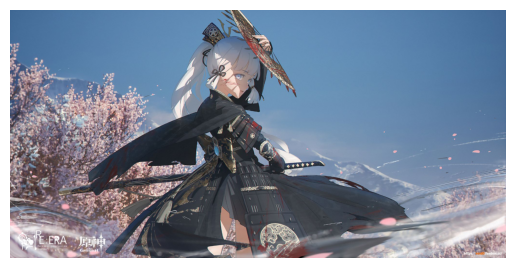

In [47]:
def remote_image(url):
    return Image.open(BytesIO(requests.get(url).content))
image = remote_image(IMAGE_URL)
plt.imshow(image)
plt.axis('off')
plt.show()


x.shape:(1024, 2048, 3)
y.shape:(1024, 2048)



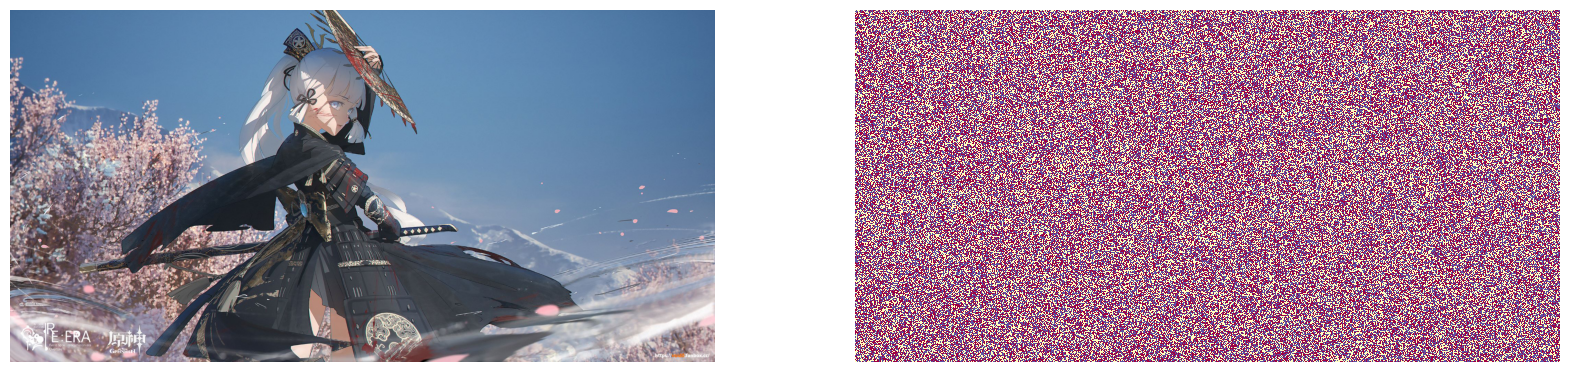

In [48]:
# random init label
x = np.array(image)
y = np.random.randint(0,N_CLASSES,size=x.shape[:-1])

def plot(x,y):
    fig,ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].imshow(x)
    ax[0].axis('off')
    ax[1].matshow(y.astype(np.float32),cmap=plt.cm.Spectral)
    ax[1].axis('off')
    plt.show()

print(f"""
x.shape:{x.shape}
y.shape:{y.shape}
""")
plot(x,y)

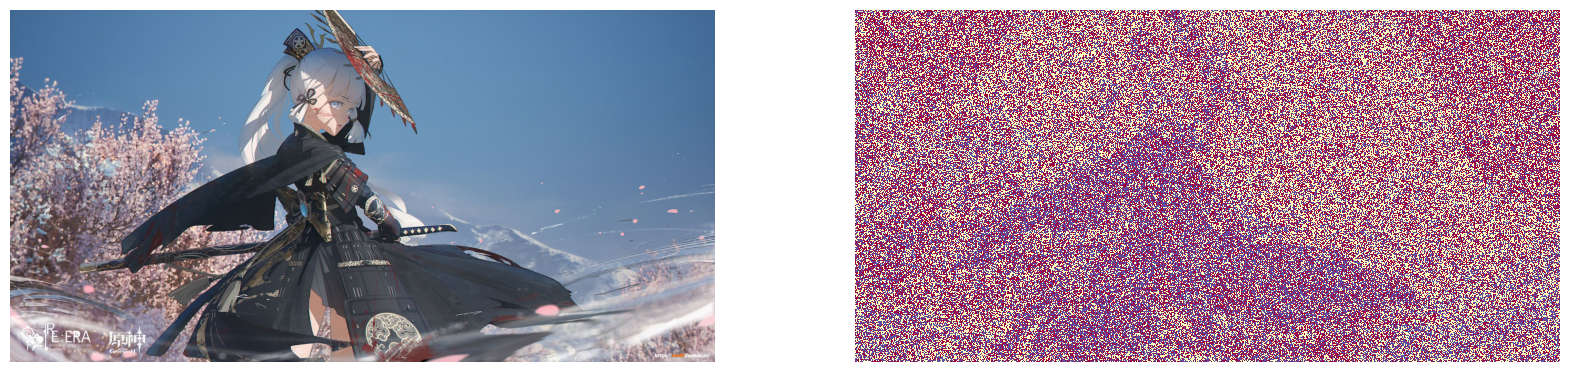

In [49]:
def mrf_once(x,y,kernel_size=3):
    '''
        Parameters
        ----------
            x:[H,W,C]
            y:[H,W]
        Returns
        -------
            [H,W]
    '''
    EPS   = 1e-7
    H,W,C = x.shape
    GAMMA = 1/np.sqrt(2*np.pi)
    x = Image.fromarray(x).convert('L').__array__()
    y = y.astype(np.uint8)
    kernel_shape = [kernel_size,kernel_size]
    full_len = kernel_size ** 2
    half_len = full_len // 2

    P_y = np.zeros((N_CLASSES,H,W),dtype=np.float32)
    P_yx= np.zeros((N_CLASSES,H,W),dtype=np.float32)

    # calcuate P(y)
    for i in range(full_len):
        # for each neighbor
        if i == half_len:
            # only consider neighbor, not the node itself
            continue
        filter2D = np.zeros(full_len,dtype=np.float32)
        filter2D[i] = 1
        filter2D = filter2D.reshape(kernel_shape)
        t = cv2.filter2D(y,-1,filter2D)
        for j in range(N_CLASSES):
            P_y[j] += (t==j).astype(np.float32)/(half_len*2)
    # set where 0 to small number in case of log operation
    P_y[P_y==0] = EPS

    # calculate P(y|x)
    for i in range(N_CLASSES):
        mask = y == i 
        elem = x[mask]
        mean = elem.mean()
        var  = elem.var()
        std  = np.sqrt(var)
        P_yx[i] = GAMMA * np.exp(-(x-mean)**2/(2*var)) / std

    P = np.log(P_y) + np.log(P_yx)
    y = P.argmax(0)
    return y

# do  markov random field for once
plot(x,mrf_once(x,y))

100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


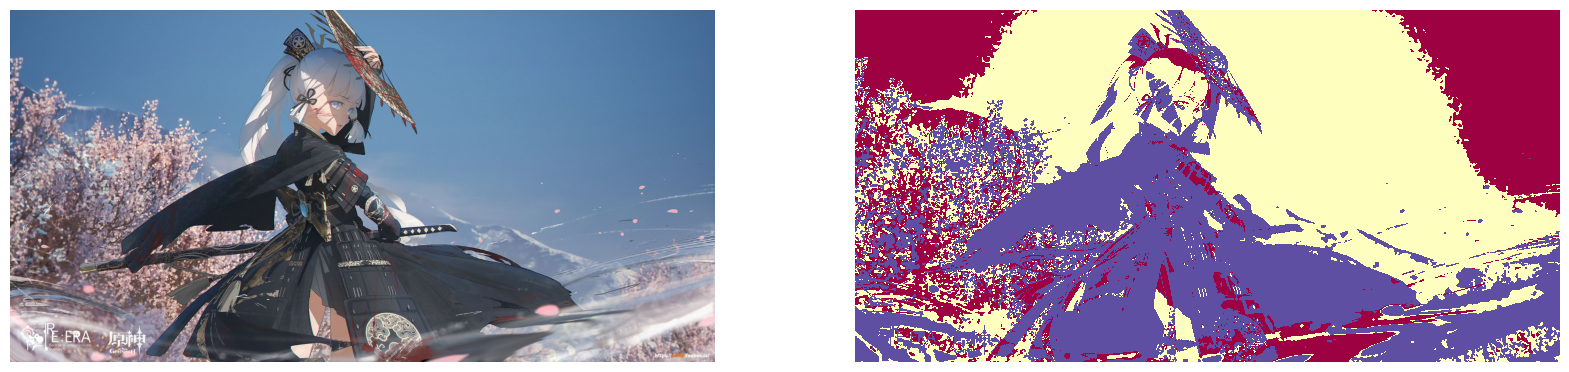

In [52]:
def mrf(x,y,times=1,kernel_size=3):
    for _ in tqdm(range(times),colour='blue'):
        y = mrf_once(x,y,kernel_size)
    plot(x,y)
mrf(x,y,20)